## Assigment 2: Word2vec and CBOW ⚡


In this assignment, we will guide you through the process of implementing Continous Bag Of Words (CBOW) using PyTorch, providing step-by-step instructions, code snippets, and explanations to aid your understanding. By the end of this assignment, you will have a solid grasp of Word2Vec's mechanics and be equipped to apply this knowledge to a wide range of NLP tasks.

Let's embark on this journey to unlock the power of word embeddings with Word2Vec and PyTorch!

This [guide](https://pytorch.org/tutorials/beginner/basics/intro.html) might come in handy to understand how Pytorch works.

Let's start by installing the needed libraries

In [36]:
!pip install datasets
# !gdown https://drive.google.com/file/d/1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu/view?usp=sharing --fuzzy

In [37]:
import torch
torch.manual_seed(0)

In this assigment we will use the data set wikitext. This dataset is composed of textual content extracted from Wikipedia articles which hopefully will lead to good embeddings when input in CBOW.

In [38]:
from datasets import load_dataset
from random import sample

wikitext = load_dataset("wikipedia", "20220301.simple")
trim_dataset= sample(wikitext['train']['text'], 5000)

Found cached dataset wikipedia (/home/o_heidar/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/d41137e149b2ea90eead07e7e3f805119a8c22dd1d5b61651af8e3e3ee736001)


  0%|          | 0/1 [00:00<?, ?it/s]

Let's have a look at a datapoint.

In [39]:
trim_dataset[0]

'The name Anita is a very common female given name. In Spanish, the name is a version of Ana, the Spanish version of Anne. In Sanskrit, Anita means "full of grace". There are many famous people with the name, including Anita Louise, singer Anita Baker, Anita Page and Anita Loos. In 1977, a Hurricane Anita hit northeastern Mexico.\n\nPeople\n Anita Østby (born 1972), Norwegian Liberal Party politician\n Anita Barone (born 1964), American actress\n Anita Brodén (born 1948), Swedish Liberal People\'s Party politician\n Anita Caspary (1915–2011), American nun, founder of Immaculate Heart of Mary Community\n Anita Ekberg (born 1931), Swedish model and actress\n Anita Jönsson (born 1947), Swedish Social Democratic politician\n Anita Louise Suazo (born 1947), Native-American potter\n Anita Neville MP (born 1942), Canadian politician\n Anita Orlund (born 1964), Norwegian Labour Party politician\n Anita Romaniuk, Canadian politician\n Anita Stewart (born 1947), Canadian culinary writer and food

As you can see there are a lot of numeric values, end-of-lines and the word "References" at the end. We saw in the previous assigment how preprocessing can significantly reduce the vocabulary; feel free to base the following code in your previous work.

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/o_heidar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
import string
import re
from nltk.corpus import stopwords
def preprocess_data(data):
  """ Method to clean text from noise and standarize text across the different classes.
      The preprocessing includes converting to joining all datapoints, lowercase, removing punctuation, and removing stopwords.
  Arguments
  ---------
  text : List of String
     Text to clean
  Returns
  -------
  text : String
      Cleaned and joined text
  """

  stop_words = set(stopwords.words('english'))

  text = ' '.join(data) #join all text in one single string
  text = text.lower() #make everything lower case
  text = text.replace('\n', ' ') #remove \n characters
  text = re.sub(r'\breferences\b', '', text) #remove word "References"
  text = text.translate(str.maketrans('', '', string.punctuation)) #remove any punctuation or special characters
  text = re.sub(r'\d+', '', text) #remove all numbers
  text = ' '.join([word for word in text.split() if word not in stop_words]) #remove all stopwords (see imports to help you with this)

  return text

text=preprocess_data(trim_dataset)

Our `text` variable includes all the data in just one string. Let's create a dictionary of frequencies for more pre-processing (same as in the last assigment).

In [42]:
def vocab_frequency(text):
  """ Creates dictionary of frequencies based on a dataset.
  Arguments
  ---------
  dataset : list of tuples
      list of tuples of the form (label, text)
  Returns
  -------
  vocab_dict : dictonary
      Dictionary of words and their frequencies with the format {word: frequency}
  """
  vocab_dict = {}
  #TODO same as assignment 1

  for word in text.split(" "):
    if word in vocab_dict:
      vocab_dict[word] += 1
    else:
      vocab_dict[word] = 1
  return vocab_dict

vocabulary = vocab_frequency(text)

In [43]:
len(vocabulary)

61949

Now our vocabulary is ready 😎

Since our neural networks can't understand strings we have to turn these strings into integers. In this case, we can use the vocabulary index to represent the words, so we will need the mapping: word -> index

In [44]:
import torch
import torch.nn as nn
def word_to_index(vocabulary):
  """ Method to create vocabulary to index mapping.
  Arguments
  ---------
  vocabulary : Dictionary
     Dictonary of format {word:frequency}
  Returns
  -------
  word_to_index : Dictionary
      Dictionary mapping words to index with format {word:index}
  """
  word_to_index = {}
  #Create key,value pair for out of vocabulary worlds
  #TODO
  for idx, word in enumerate(vocabulary):
      word_to_index[word] = idx
  return word_to_index

word_to_index = word_to_index(vocabulary)

Let's start to get more on topic. If you remember, Word2Vec has a specific way of generating each vector.
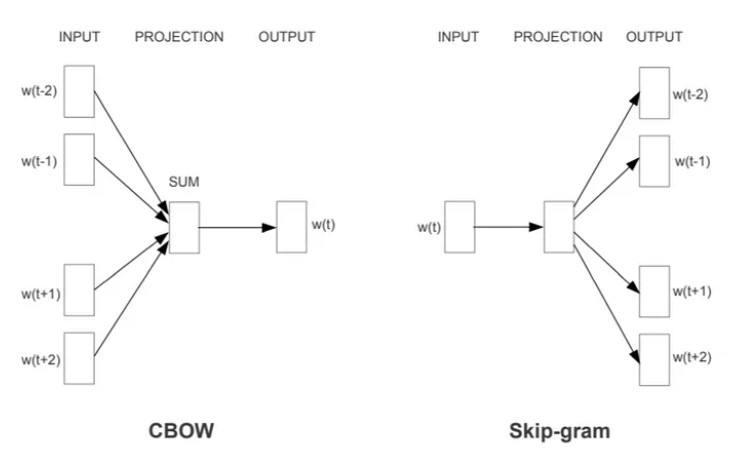

The embedding is based on the surrounding words (before and after) taken as context. In the case of CBOW, we input the surrounding words to our neural network and expect that it predicts the middle word. Let's format our dataset to meet the needs of the neural network.


In [45]:
def generate_dataset(data, window_size, word_to_index):
  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  surroundings= []
  targets = []
  data= data.split(" ")
  #TODO complete function
  for i in range(window_size,len(data)-window_size):
    surrounding = [word_to_index[data[j]] for j in range(i - window_size, i + window_size + 1) if j != i] # Get the surrounding words as a list of indices.
    target = word_to_index[data[i]] #get target word (middle word)
    surroundings.append(surrounding) #append to surrounding
    targets.append(target) #append to targets
  surroundings = torch.tensor(surroundings, dtype=torch.long)
  targets = torch.tensor(targets, dtype=torch.long)
  return surroundings, targets

t_surroundings, t_targets = generate_dataset(text,2,word_to_index)

With our dataset ready we can finally create our Neural Network. The idea is to replicate what Mikolov did in 2013 (see slides of Word2Vec).

In [46]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer
    """
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim) #use this layer to get a vector from the the word index
    self.linear = nn.Linear(embed_dim, vocab_size) #first fully connected layer (bottleneck)

  def forward(self, x):
    emb = self.embedding(x) #pass input through embedding layer
    average = emb.mean(dim=1) #average and resize (size must be batch_size x embed_dim)
    out = self.linear(average) #pass through linear layer

    return out

In [47]:
from torch.utils.data import DataLoader
#creation of dataloader for training
train_dataloader=DataLoader(list(zip(t_surroundings,t_targets)),batch_size=64,shuffle=True) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)

In [48]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
model = CBOW(len(word_to_index)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

#BE PATIENT: This code can take up to 2 hours and 10 min for a batch size of 64 and 10 epochs
for epoch in range(epochs):
    total_loss = 0
    i=0
    for surr, tar in tqdm(train_dataloader):
        #TODO: create code for training our model
        surr, tar = surr.to(device), tar.to(device)
        outputs = model(surr)
        loss = loss_function(outputs, tar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {total_loss/len(train_dataloader)}")

100%|██████████| 7877/7877 [01:02<00:00, 126.78it/s]


Epoch 1 loss: 8.822001868189025


100%|██████████| 7877/7877 [01:01<00:00, 128.80it/s]


Epoch 2 loss: 6.672056605644269


100%|██████████| 7877/7877 [01:02<00:00, 126.17it/s]


Epoch 3 loss: 5.485172053619555


100%|██████████| 7877/7877 [01:02<00:00, 125.96it/s]


Epoch 4 loss: 4.600894576540389


100%|██████████| 7877/7877 [01:00<00:00, 129.96it/s]


Epoch 5 loss: 3.892171695932483


100%|██████████| 7877/7877 [01:01<00:00, 128.45it/s]


Epoch 6 loss: 3.322840715765242


100%|██████████| 7877/7877 [00:59<00:00, 132.17it/s]


Epoch 7 loss: 2.8790746322664282


100%|██████████| 7877/7877 [01:01<00:00, 127.65it/s]


Epoch 8 loss: 2.526110079259123


100%|██████████| 7877/7877 [01:01<00:00, 127.17it/s]


Epoch 9 loss: 2.237241094270091


100%|██████████| 7877/7877 [01:01<00:00, 128.87it/s]

Epoch 10 loss: 1.9857391023887085


## Let's test it! 🤓

Now that we hopefully have good embeddings we can put them to the test. Let's start by creating some useful functions.

In [53]:
def get_embedding(word, model, word_to_index):
  """ Method to get the embedding vector for a given word.
  Arguments
  ---------
  word : String
     Word given
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  word_embedding : Tensor
      Embedding vector for the given word
    """
  index = word_to_index.get(word, None) # get word index

  with torch.no_grad():
        embedding_weights = model.embedding.weight # Get the weights of the embedding layer
        embedding_weights.requires_grad = False
        word_embedding = embedding_weights[index] # Extract the embedding vector for the given word index

  return word_embedding

get_embedding("shot",model,word_to_index) #test this code by getting embedding of the word "shot"

tensor([ 4.0942e-01, -1.5980e-02,  1.1885e+00, -7.8792e-01,  2.5931e-01,
        -3.0227e+00, -9.7181e-01, -3.2388e+00,  1.7592e+00,  6.0300e-01,
        -1.2098e-01, -1.1258e+00,  1.3868e+00, -3.1660e+00,  1.1271e+00,
        -4.8108e-01, -9.5016e-01, -3.0343e-02,  5.7120e-01,  2.1450e-01,
        -4.0904e-01, -5.5620e-01,  2.0241e+00,  2.0720e+00, -2.5113e-01,
         1.0451e+00, -1.2820e+00, -9.5662e-01, -9.1020e-02, -1.6183e+00,
        -1.2770e+00, -1.7391e+00, -1.9826e+00, -1.0178e+00,  1.5914e+00,
        -1.3181e+00,  1.4421e+00,  3.3644e-03,  1.4685e+00,  1.4966e+00,
         8.3007e-02, -3.3674e-01,  2.1002e+00, -2.0264e-02,  8.1162e-01,
         1.1113e-01, -1.8299e-01,  8.4599e-02,  1.6523e+00,  4.6905e-01,
         4.0511e-01, -2.0712e-01, -7.9035e-02,  3.7719e-01, -7.1657e-02,
        -2.3624e+00, -4.3244e-01, -2.3468e+00, -4.8657e-01, -1.5863e+00,
         3.7016e-01,  4.6172e-01, -5.4476e-01, -1.4723e+00,  2.0740e-01,
         2.1157e+00,  6.1604e-02,  1.1116e+00,  2.9

In [54]:
def cosine_similarity(v1,v2):
  """ Method to calculate cosine similarity between two vectors.
  Arguments
  ---------
  v1 : Tensor
     First vector
  v2 : Tensor
     Second vector
  Returns
  -------
  cosine_similarity : float
      Cosine similarity between v1 and v2
  """
  # Calculate the dot product between the two vectors
  dot_product = torch.dot(v1, v2)

  # Calculate the magnitude (L2 norm) of each vector
  magnitude_v1 = torch.norm(v1)
  magnitude_v2 = torch.norm(v2)

  # Compute cosine similarity
  cosine_similarity = dot_product / (magnitude_v1 * magnitude_v2)
  return #TODO create expression to calculate cosine similarity

In [71]:
def get_k_nearest_words(k, word, vocabulary,model,word_to_index):
  """ Method to find the k nearest words of a given vector
  Arguments
  ---------
  k : int
     Number of nearest words to return
  word : torch.Tensor
     Embedding vector for the given word
  vocabulary : Dictionary
     Dictionary mapping words to frequency with format {word:frequency}
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  similar : List of Strings
      List of k nearest words to the given word
  """
  similarity_scores= torch.zeros(len(vocabulary))
  #fill similarity scores matrix using the word and our cosine_similarity function
  word_vector = get_embedding(torch.tensor([word_to_index[word]]).to(device), model, word_to_index)
  for i, vocab_word in enumerate(vocabulary):
      vocab_word_vector = get_embedding(torch.tensor([word_to_index[vocab_word]]).to(device), model, word_to_index)
      similarity_scores[i] = cosine_similarity(word_vector, vocab_word_vector)
  k_first= torch.topk(similarity_scores,k)
  similar=[]
  #TODO: create a function to get the k nearest words to a certain chosen word. TIP: use pytorch's topk
  top_k_indices = torch.topk(similarity_scores, k).indices
  similar = [list(vocabulary.keys())[i] for i in top_k_indices]

  return similar


The Google analogy test set is a state of the art data set for word embeddings that tests their ability to solve analogy tasks. A well-known example for it is: "king is to man as queen is to women." We will use a subset of this dataset to see how our CBOW model performs.


In [72]:
import pandas as pd

def test_analogy(model, word_to_index, analogy_file):
  """ Method to test accuracy of CBOW embeddings on analogy tasks.
  Arguments
  ---------
  mode : nn.Module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  analogy_file : String
     File containing analogy tasks
  Returns
  -------
  accuracy : float
      accuracy of the model on the analogy tasks
  """
  df = pd.read_csv(analogy_file)
  df = df[df.category=='capital-common-countries'] #using capital cities subset of test set
  correct = 0
  total = 0
  for index,row in df.iterrows():

    word_one = row['word_one'].lower() #extract word number 1
    word_two = row['word_two'].lower() #extract word number 2
    word_three = row['word_three'].lower() #extract word number 3
    word_four = row['word_four'].lower() #extract word number 4

    #remember to standarize the words by using .lower

    #create exception in case word is not in vocabulary
    if word_one not in word_to_index or word_two not in word_to_index or word_three not in word_to_index or word_four not in word_to_index:
        continue
    #get embedding of all words
    embedding_word_1 = get_embedding(torch.tensor([word_to_index[word_one]]).to(device), model, word_to_index)
    embedding_word_2 = get_embedding(torch.tensor([word_to_index[word_two]]).to(device), model, word_to_index)
    embedding_word_3 = get_embedding(torch.tensor([word_to_index[word_three]]).to(device), model, word_to_index)
    embedding_word_4 = get_embedding(torch.tensor([word_to_index[word_four]]).to(device), model, word_to_index)
        
    result = embedding_word_2-embedding_word_1-embedding_word_3# calculate embedding_word_2-embedding_word_1+embedding_word_3
    prediction = get_k_nearest_words(10, result, word_to_index, model, word_to_index) #call the k_nearest function you created before (set k to 10)

    #if word_four is in prediction, add one to correct
    if word_four in prediction:
        correct += 1
    total+=1
  if total != 0:
    accuracy=correct/total
  else:
    return 'No word was found in the embeddings '
  return accuracy

test_analogy(model,word_to_index,'TestSet_sample.csv')

KeyError: tensor([[[ 1.4412,  1.3119,  0.9119,  ..., -1.1091,  0.8033, -0.7590],
         [-1.8418,  0.1568, -1.5956,  ...,  1.4859,  0.0606, -0.7052],
         [-0.4758, -3.1754, -1.1052,  ...,  1.8610, -1.7136,  0.4476],
         ...,
         [ 0.4034, -0.7718, -0.2218,  ...,  0.0725,  1.2114, -1.0447],
         [-0.1578,  0.1940, -0.9108,  ...,  0.9923, -1.1298,  0.4892],
         [ 2.0340,  1.5866,  0.4931,  ...,  0.3160, -1.0048, -1.5579]]],
       device='cuda:0')

Our model can do much better! In the "Let's experiment" part we will try to improve this model. Also depending on your GPU accesibility you can train for more epochs and data (making trim_dataset bigger in cell #3).

TSNE can be a very helpful and cool visualization method of our vectors, this way we can clearly see the relationship between different words (maybe even find some clusters!). Let's implement this visualization.

In [ ]:
import numpy as np
import pandas as pd
import torch
import sys

from sklearn.manifold import TSNE
import plotly.graph_objects as go

tsne = #create TSNE
embeddings = #get embeddings by detaching weights of embedding layer (use only first 1000 words)
#TODO create TSNE plot to visualize the relationship between our vectors

## Let's Experiment!

Now it's your time to experiment.
- Find a new training corpus to train our CBOW model from scratch (it can be books, tweets, etc).  This should change the embeddings. Analyse and report how this new training set changes the vectors themselves and the accuracy on the analogy test.
- Test your embeddings on a different sub-section of the analogy dataset or another dataset. Analyse and report how these results compare with the original dataset.